In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

import fastmri
from fastmri.data import transforms as T

#### Input file name: 
ground truth \
subsampled data before reconstruction \
reconstruction using pre-trained model \
reconstruction using "together" model - trained by all 5 different types of images \
reconstruction using "FLAIR" model - trained by only FLAIR 

In [2]:
# filename

file_name = "file_brain_AXT2_202_2020013.h5"
MaskType = "e"
AccelerationRate = "8"

# file before reconstruction
file_before_recon_name = "./undersampling/" + MaskType + "_sub" + AccelerationRate + "_" + file_name
file_gt_name = "./undersampling/" + file_name
file_pre_trained = "./test_recon/" + \
                                "8.9_reconstructions/" + "pre-trained/sub_" + \
                                file_name

# together.ckpt: max_epochs = 100; ssim=0.9353; save ckpt according to 'validation_loss'
# file_100_recon_name = "./test_recon/" + \
#                                 "8.9_reconstructions/" + "together/sub_" + \
#                                 file_name
file_100_recon_name = "test_recon/" + \
                      "8.19_reconstructions/100_" + MaskType + "_recon_" + AccelerationRate + MaskType + "/" + \
                      MaskType + "_sub" + AccelerationRate + "_" + file_name

# 200_out.ckpt: max_epochs = 200; ssim=0.9373; save ckpt according to 'validation_loss'
file_200_recon_name = "test_recon/" + \
                      "8.19_reconstructions/200_" + MaskType + "_recon_" + AccelerationRate + MaskType + "/" + \
                      MaskType + "_sub" + AccelerationRate + "_" + file_name

Read in all the files (k-space) and transform data (IFFT - taking absolute value - rss)

In [3]:
# original gt img
gt = h5py.File(file_gt_name, 'r')
max_value = gt.attrs["max"] if "max" in gt.attrs.keys() else 0.0
gt_kspace = gt['kspace'][()]
def get_gt_slice(slice_idx):
    gt_slice_kspace = gt_kspace[slice_idx]
    gt_slice_kspace2 = T.to_tensor(gt_slice_kspace)      
    gt_slice_img = fastmri.ifft2c(gt_slice_kspace2)           
    gt_slice_img_abs = fastmri.complex_abs(gt_slice_img)
    gt_slice_img_rss = fastmri.rss(gt_slice_img_abs, dim=0).numpy()
    gt_slice_img_rss_abs_array = np.abs(gt_slice_img_rss)
    return gt_slice_img_rss_abs_array

# before recon
hf_before_recon = h5py.File(file_before_recon_name, 'r')
sub_volume_kspace = hf_before_recon['kspace'][()]
def get_sub_slice(slice_idx):
    sub_slice_kspace = sub_volume_kspace[slice_idx]
    sub_slice_kspace2 = T.to_tensor(sub_slice_kspace)      
    sub_slice_img = fastmri.ifft2c(sub_slice_kspace2)  
    sub_slice_img_abs = fastmri.complex_abs(sub_slice_img)   
    sub_slice_img_rss = fastmri.rss(sub_slice_img_abs, dim=0).numpy()
    sub_slice_img_rss_abs_array = np.abs(sub_slice_img_rss)
    return sub_slice_img_rss_abs_array

# after recon
hf_after_recon_pre = h5py.File(file_pre_trained, 'r')
hf_after_recon_100 = h5py.File(file_100_recon_name, 'r')
hf_after_recon_200 = h5py.File(file_200_recon_name, 'r')


volume_img_after_recon_pretrained = hf_after_recon_pre['reconstruction']
volume_img_after_recon_100 = hf_after_recon_100['reconstruction']
volume_img_after_recon_200 = hf_after_recon_200['reconstruction']

In [4]:
print(gt_kspace.shape)  # (number of slices, number of coils, height, width)
slice_idx_lst = range(gt_kspace.shape[0])

(16, 20, 640, 320)


#### Calculate SSIM

In [5]:
# ssim calculation
from fastmri.data import transforms
import torch
from skimage.metrics import structural_similarity as ssim

def loss_ssim(img_array, i, max_v=0.0):
    gt_array=get_gt_slice(i)
    target, output = transforms.center_crop_to_smallest(gt_array, img_array)
    loss_ssim = ssim(output, target, win_size=7, data_range=max_v)
    return loss_ssim

#### Calculate PSNR

In [6]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def loss_psnr(img_array, i):
    gt_array=get_gt_slice(i)
    target, output = transforms.center_crop_to_smallest(gt_array, img_array)
    loss_psnr = psnr(target, output, data_range=max_value)
    return loss_psnr

#### Plot figure
All slices in a volume 

Ground truth (SSIM for subsampled data) | pre-trained model | together model | FLAIR model 

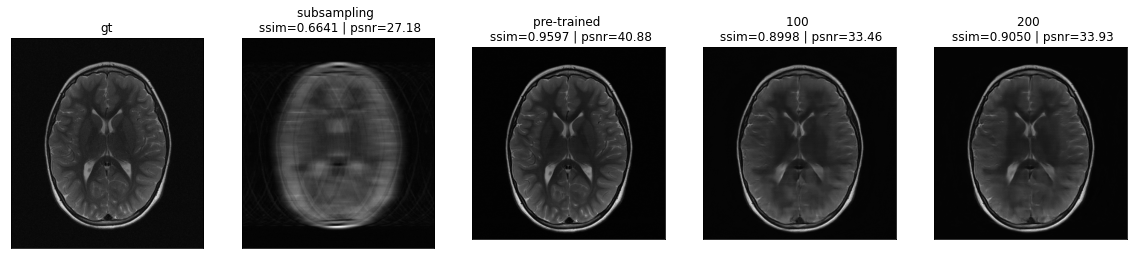

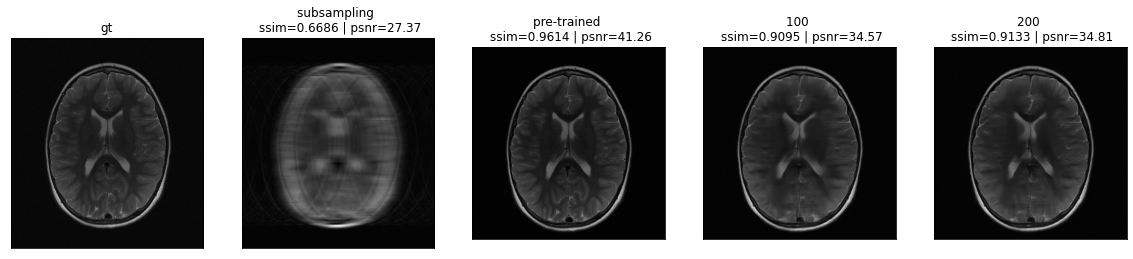

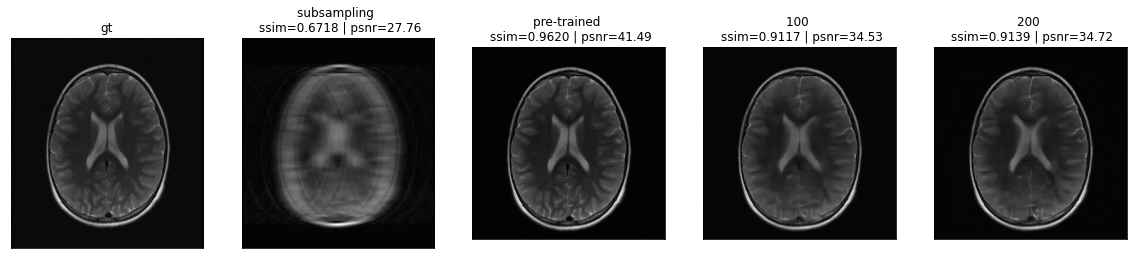

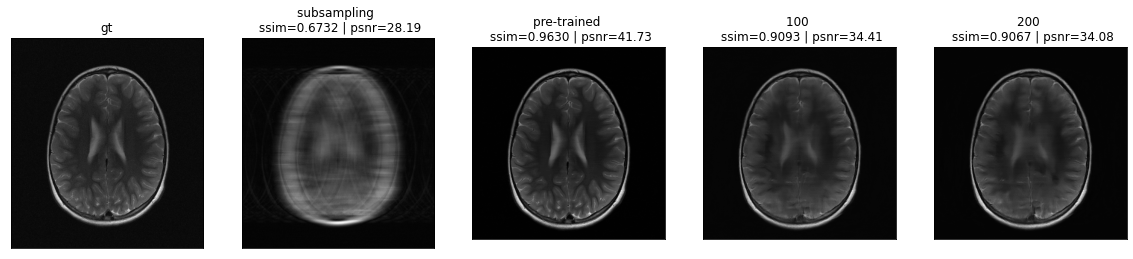

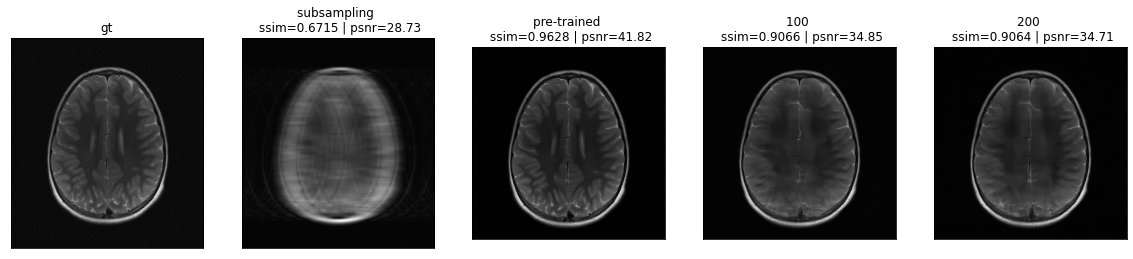

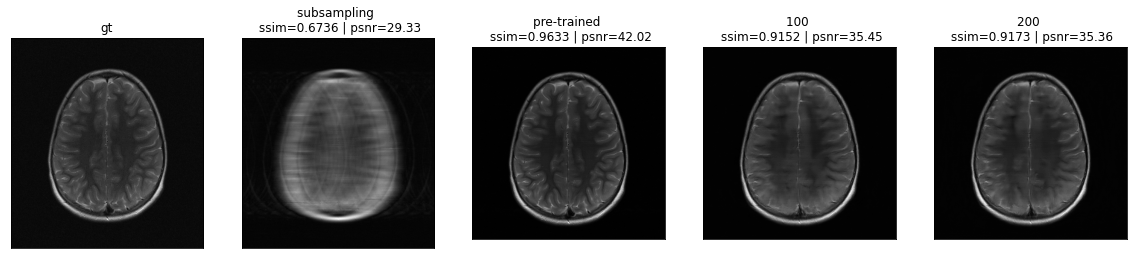

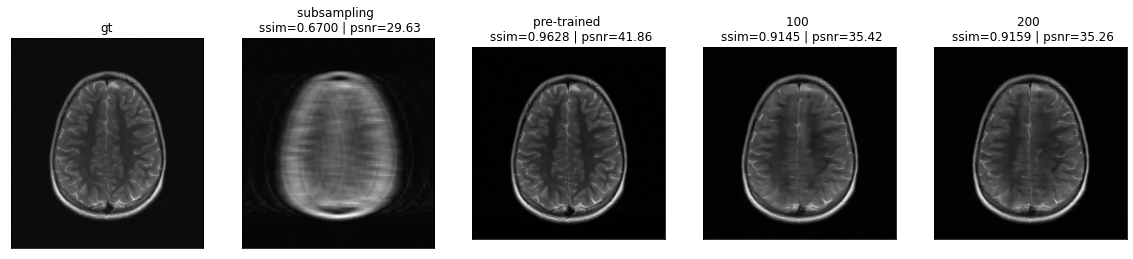

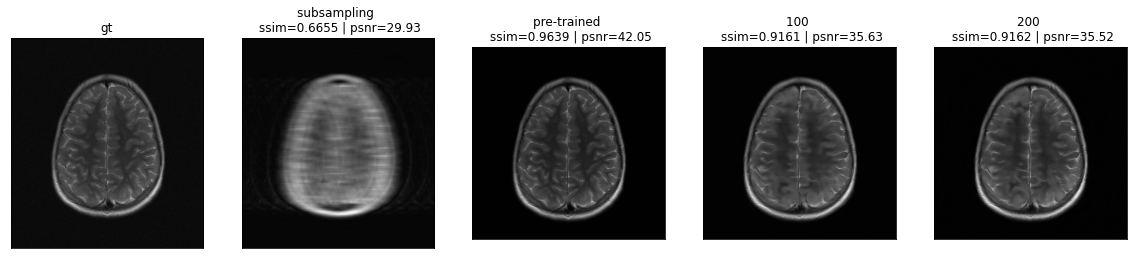

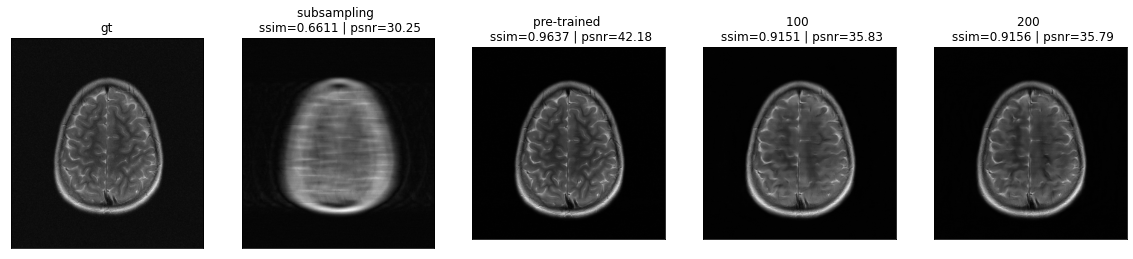

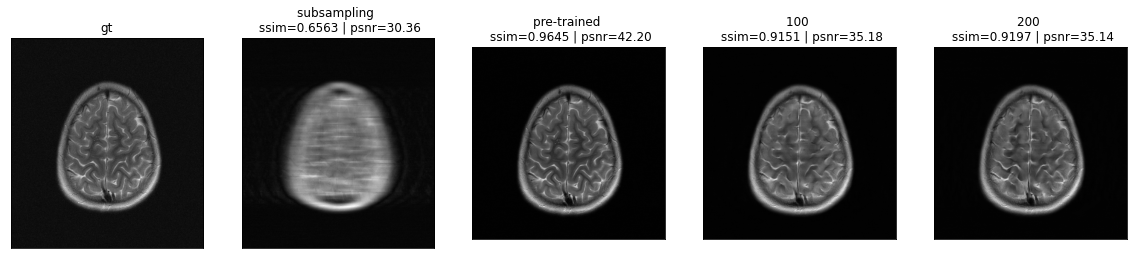

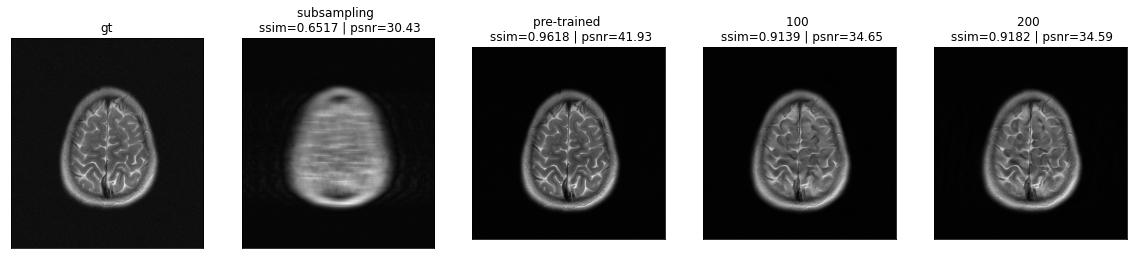

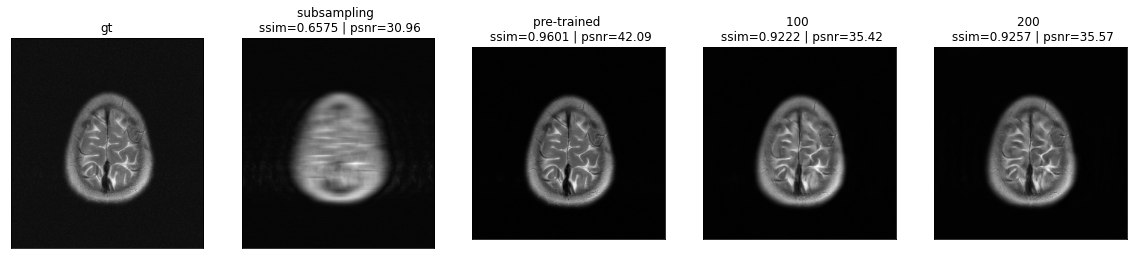

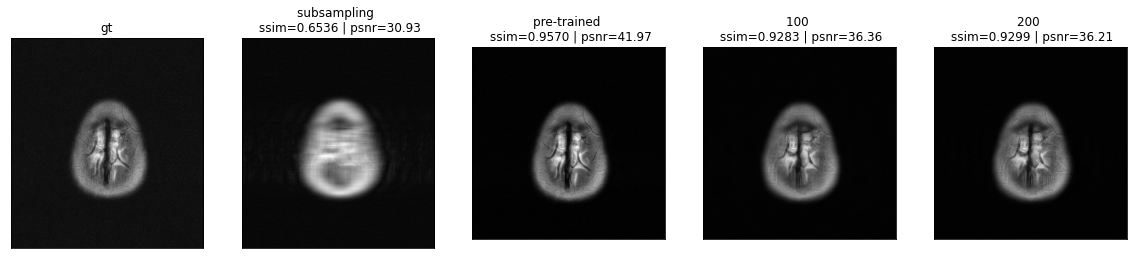

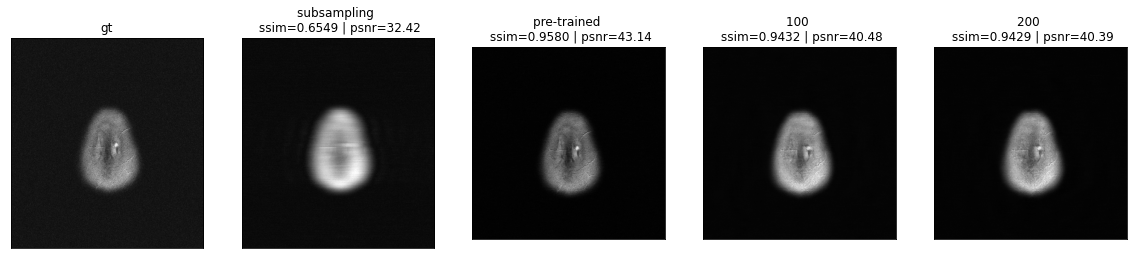

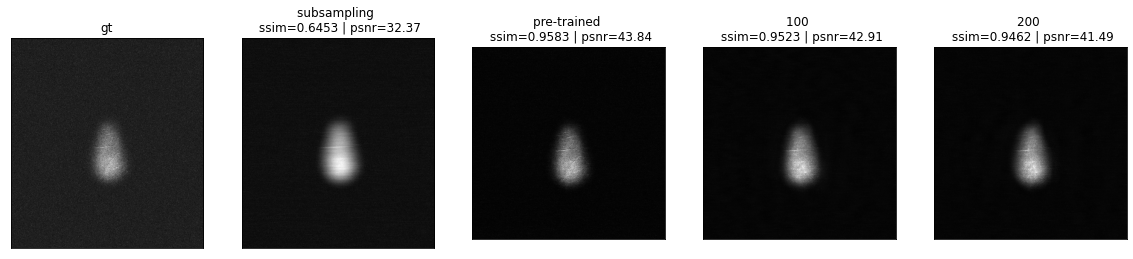

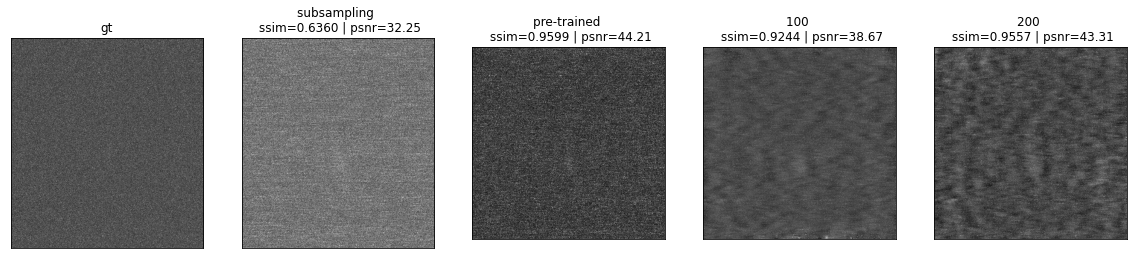

In [7]:
# row_number = gt_kspace.shape[0]
col_number = 5
pre_ssim_lst = []
pre_psnr_lst = []
ssim_lst_100 = []
psnr_lst_100 = []
ssim_lst_200 = []
psnr_lst_200 = []

for idx in slice_idx_lst:
    fig, axs = plt.subplots(1, col_number, figsize=(20, 16))  # change row & column
    
    axs[0].set_ylim(500, 150)
    gt = get_gt_slice(idx)
    sub = get_sub_slice(idx)
    axs[0].imshow(gt[::-1, ::], cmap='gray')
    axs[0].set_title("gt")
    axs[0].axes.xaxis.set_ticklabels([])
    axs[0].axes.yaxis.set_ticklabels([])
    axs[0].axes.xaxis.set_ticks([])
    axs[0].axes.yaxis.set_ticks([])
    
    axs[1].set_ylim(500, 150)
    axs[1].axes.xaxis.set_ticklabels([])
    axs[1].axes.yaxis.set_ticklabels([])
    axs[1].axes.xaxis.set_ticks([])
    axs[1].axes.yaxis.set_ticks([])
    axs[1].imshow(sub[::-1, ::], cmap='gray')
    loss_1 = loss_ssim(sub, idx, max_v=max_value)
    loss_2 = loss_psnr(sub, idx)
    axs[1].set_title("subsampling \n ssim={:.4f} | psnr={:.2f}".format(loss_1, loss_2))
    
    
    axs[2].set_ylim(320, 0)
    axs[2].axes.xaxis.set_ticklabels([])
    axs[2].axes.yaxis.set_ticklabels([])
    axs[2].axes.xaxis.set_ticks([])
    axs[2].axes.yaxis.set_ticks([])
    axs[2].imshow(volume_img_after_recon_pretrained[idx][::-1, ::], cmap='gray')
    loss_1 = loss_ssim(volume_img_after_recon_pretrained[idx], idx, max_v=max_value)
    loss_2 = loss_psnr(volume_img_after_recon_pretrained[idx], idx)
    axs[2].set_title("pre-trained \n ssim={:.4f} | psnr={:.2f}".format(loss_1, loss_2))
    pre_ssim_lst.append(loss_1) 
    pre_psnr_lst.append(loss_2)

    
    axs[3].set_ylim(320, 0) 
    axs[3].axes.xaxis.set_ticklabels([])
    axs[3].axes.yaxis.set_ticklabels([])
    axs[3].axes.xaxis.set_ticks([])
    axs[3].axes.yaxis.set_ticks([])
    axs[3].imshow(volume_img_after_recon_100[idx][::-1, ::], cmap='gray')
    loss_1 = loss_ssim(volume_img_after_recon_100[idx], idx, max_v=max_value)
    loss_2 = loss_psnr(volume_img_after_recon_100[idx], idx)
    axs[3].set_title("100 \n ssim={:.4f} | psnr={:.2f}".format(loss_1, loss_2))
    ssim_lst_100.append(loss_1)
    psnr_lst_100.append(loss_2)
    
    
    axs[4].set_ylim(320, 0)  
    axs[4].axes.xaxis.set_ticklabels([])
    axs[4].axes.yaxis.set_ticklabels([])
    axs[4].axes.xaxis.set_ticks([])
    axs[4].axes.yaxis.set_ticks([])
    axs[4].imshow(volume_img_after_recon_200[idx][::-1, ::], cmap='gray')
    loss_1 = loss_ssim(volume_img_after_recon_200[idx], idx, max_v=max_value)
    loss_2 = loss_psnr(volume_img_after_recon_200[idx], idx)
    axs[4].set_title("200 \n ssim={:.4f} | psnr={:.2f}".format(loss_1, loss_2))
    ssim_lst_200.append(loss_1)
    psnr_lst_200.append(loss_2)
    
    
    plt.show();

In [8]:
pre_ssim_avg = np.mean(pre_ssim_lst)
pre_psnr_avg = np.mean(pre_psnr_lst)
pre_ssim_std = np.std(pre_ssim_lst)
pre_psnr_std = np.std(pre_psnr_lst)

one_ssim_avg = np.mean(ssim_lst_100)
one_psnr_avg = np.mean(psnr_lst_100)
one_ssim_std = np.std(ssim_lst_100)
one_psnr_std = np.std(psnr_lst_100)

two_ssim_avg = np.mean(ssim_lst_200)
two_psnr_avg = np.mean(psnr_lst_200)
two_ssim_std = np.std(ssim_lst_200)
two_psnr_std = np.std(psnr_lst_200)

print("pre ssim avg: {} \t std: {}\n".format(pre_ssim_avg, pre_ssim_std))
print("pre psnr avg: {} \t std: {}\n".format(pre_psnr_avg, pre_psnr_std))
print("100 ssim avg: {} \t std: {}\n".format(one_ssim_avg, one_ssim_std))
print("100 psnr avg: {} \t std: {}\n".format(one_psnr_avg, one_psnr_std))
print("200 ssim avg: {} \t std: {}\n".format(two_ssim_avg, two_ssim_std))
print("200 psnr avg: {} \t std: {}\n".format(two_psnr_avg, two_psnr_std))

pre ssim avg: 0.9613891741139509 	 std: 0.002222043278396208

pre psnr avg: 42.167612566771865 	 std: 0.8442423467408452

100 ssim avg: 0.9185728478361459 	 std: 0.01292863177118936

100 psnr avg: 36.11466586955958 	 std: 2.4108917105946905

200 ssim avg: 0.9217806367506074 	 std: 0.014353738332711311

200 psnr avg: 36.30457401812047 	 std: 2.717716039001985



#### Summary
This file is aimed to test the influence of #training_epochs. \
Setting: \
$\quad$ Training dataset: 5 types together \
$\quad$ Training Masktype: 4+8 mixture + equispaced \
$\quad$ Reconstrution Masktype: 4 or 8 + equispaced 


For reconstructing equispaced 4 times acceleration: 200 epochs behaves almost the same as 100 epochs. \
（200 slightly better than 100: "file_brain_AXFLAIR_201_6002868.h5"）\
For reconstructing equispaced 8 times acceleration: 100 > 200
(self-trained worse than pre-trained: "file_brain_AXFLAIR_200_6002447.h5")


In all, 100 > 200. 300 almost converges. 